In [1]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

C:\Users\johbr\AppData\Local\Temp\ipykernel_21176\138741423.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
# import data
df = pd.read_csv("../resources/ames_housing_data.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# display numerical features
df_num = df.select_dtypes(include=["float64", "int64"])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


## Data Preprocessing

In [4]:
# fill missing values with the mean for each numerical feature
df = df.fillna(df_num.mean())

In [5]:
# drop 'Id'
df = df.drop("Id", axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# drop outliers (rooms with more than 4000 square feet)
df = df[df.GrLivArea <= 4000]


In [7]:
# feature engineer new series
df['TotalLivArea'] = df.GrLivArea + df.TotalBsmtSF - df.BsmtUnfSF

In [8]:
# feature engineer new room metric
df['TotalRooms'] = df.BedroomAbvGr + df.KitchenAbvGr + df.FullBath + df.HalfBath + df.BsmtFullBath + df.BsmtHalfBath

In [9]:
df = df[['OverallQual', 'OverallCond', 'TotalLivArea', 'TotalRooms', 'YearBuilt', 'SaleCondition', 'Neighborhood', 'SalePrice']]
df.head()

,OverallQual,OverallCond,TotalLivArea,TotalRooms,YearBuilt,SaleCondition,Neighborhood,SalePrice
0,7,5,2416,8,2003,Normal,CollgCr,208500
1,6,8,2240,7,1976,Normal,Veenker,181500
2,7,5,2272,8,2001,Normal,CollgCr,223500
3,7,5,1933,6,1915,Abnorml,Crawfor,140000
4,8,5,2853,9,2000,Normal,NoRidge,250000


In [10]:
# drop Blueste Neighborhood (which has only two values and a weird outlier)
print(len(df))
df.drop(df[df['Neighborhood'] == 'Blueste'].index, inplace=True)
print(len(df))

1456
1454


In [11]:
df.Neighborhood.value_counts()

Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     39
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Name: count, dtype: int64

In [12]:
# bin small neighborhoods
neighborhood_cutoff = 30
neighborhood_counts = df.Neighborhood.value_counts()
Neighborhoods_to_replace = neighborhood_counts[neighborhood_counts < neighborhood_cutoff].index

# loop to replace in df
for neighborhood in Neighborhoods_to_replace:
    df['Neighborhood'] = df.Neighborhood.replace(neighborhood, "Other")

# check that binning was successful
df.Neighborhood.value_counts()

Neighborhood
NAmes      225
CollgCr    150
Other      148
OldTown    113
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     39
Timber      38
IDOTRR      37
Name: count, dtype: int64

In [13]:
# drop unusual sale conditions
print(len(df))
df = df[df['SaleCondition'] == 'Normal']
print(len(df))

1454
1195


In [14]:
# get_dummies for categorical data
dummies = pd.get_dummies(df)
dummies.head()

,OverallQual,OverallCond,TotalLivArea,TotalRooms,YearBuilt,SalePrice,SaleCondition_Normal,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,...,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_Timber
0,7,5,2416,8,2003,208500,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,6,8,2240,7,1976,181500,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,7,5,2272,8,2001,223500,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,8,5,2853,9,2000,250000,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
5,5,5,2094,5,1993,143000,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


SalePrice               1.000000
OverallQual             0.792207
TotalLivArea            0.771283
TotalRooms              0.505795
YearBuilt               0.504184
Neighborhood_NoRidge    0.368556
Neighborhood_NridgHt    0.322167
Neighborhood_Timber     0.145744
Neighborhood_Somerst    0.131268
Neighborhood_CollgCr    0.098121
Neighborhood_Crawfor    0.085845
Neighborhood_NWAmes     0.066824
Neighborhood_SawyerW    0.051623
Neighborhood_Gilbert    0.051341
Neighborhood_Other      0.015815
OverallCond            -0.050749
Neighborhood_Mitchel   -0.054602
Neighborhood_Sawyer    -0.136080
Neighborhood_IDOTRR    -0.154211
Neighborhood_BrkSide   -0.158061
Neighborhood_NAmes     -0.179340
Neighborhood_OldTown   -0.179561
Neighborhood_Edwards   -0.188333
SaleCondition_Normal         NaN
Name: SalePrice, dtype: float64


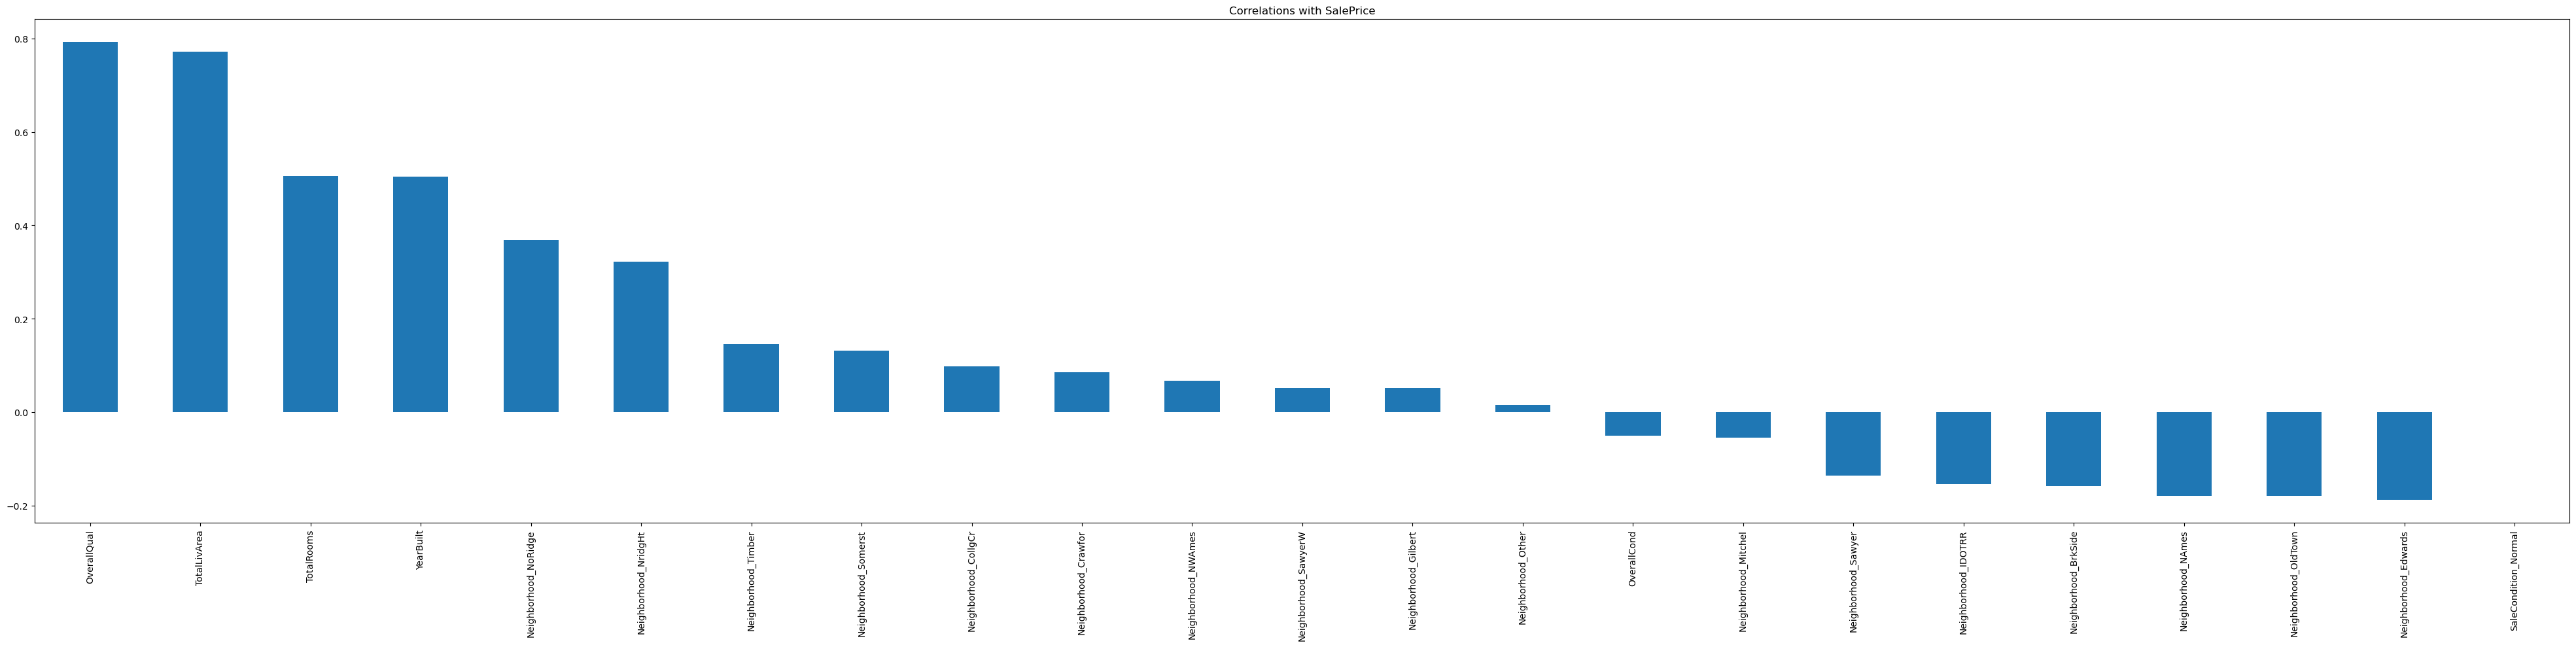

<Figure size 4000x1000 with 0 Axes>

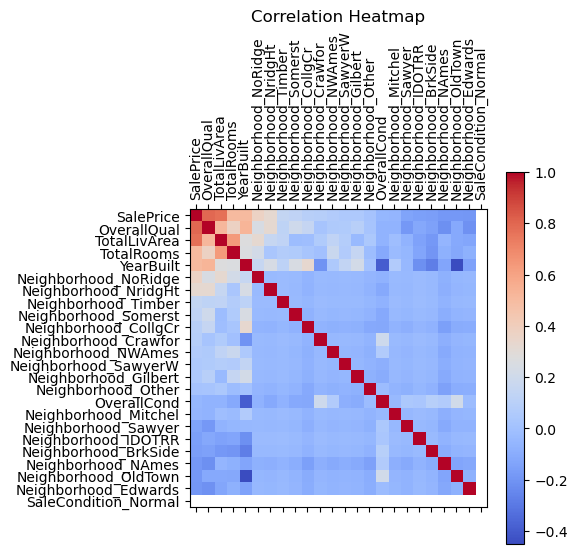

In [15]:
# calculate correlations
correlations = dummies.corr()['SalePrice'].sort_values(ascending=False)

# disable pandas display truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# print correlations
print(correlations)

# reset pandas truncation
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

# plot correlations bar chart
plt.figure(figsize=(50, 10))
correlations.drop('SalePrice').plot(kind='bar')
plt.title('Correlations with SalePrice')
plt.show()

# convert correlations to a DataFrame for the heatmap
correlations_df = dummies[correlations.index].corr()

# plot a heatmap of correlations
plt.figure(figsize=(40, 10))
plt.matshow(correlations_df, cmap='coolwarm')
plt.xticks(range(len(correlations_df.columns)), correlations_df.columns, rotation=90)
plt.yticks(range(len(correlations_df.columns)), correlations_df.columns)
plt.colorbar()
plt.title('Correlation Heatmap')
plt.show()

In [16]:
# split data into target and features
y = dummies.SalePrice.values
X = dummies.drop(columns="SalePrice").values

# split data into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

# scale the data
scaler = StandardScaler()

# fit the scaler only to the training data
# to prevent data leakage (e.g., mean and standard deviation not modified by X_test and X_val)
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# df just to plot the data immediately below
scaled_df = pd.DataFrame(X_train, columns=dummies.drop(columns="SalePrice").columns)

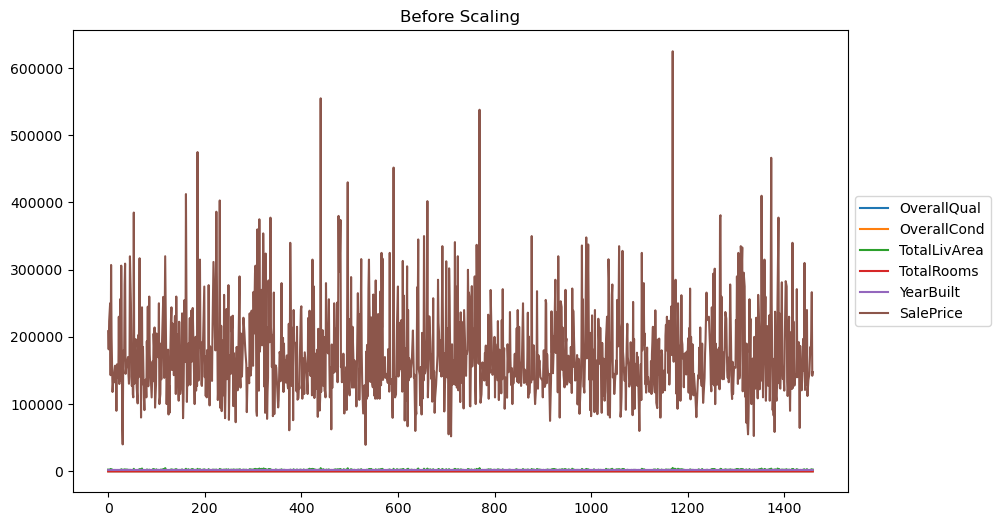

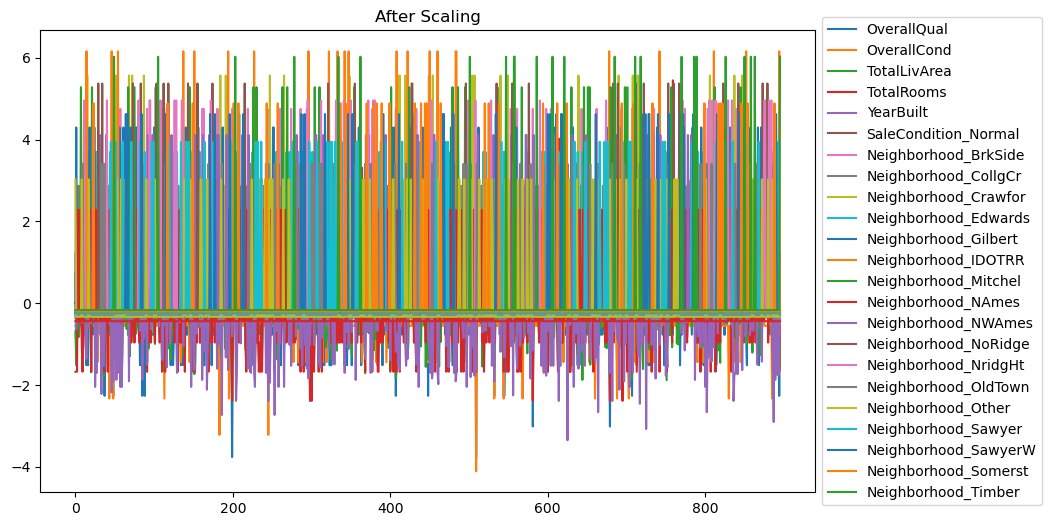

In [17]:
# plot data before scaling
dummies.plot(title='Before Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# after scaling
scaled_df.plot(title='After Scaling', figsize=(10, 6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

## Compile, Train, Evaluate the Model

In [18]:
# build keras-tuner function
def build_model(hp):
    nn_test = tf.keras.models.Sequential()

    # adds a range of 1 to 5 dense layers, allowable number of neurons (adjust based on features), activation functions
    for i in range(hp.Int("num_layers", min_value=1, max_value=5, step=1)):
        nn_test.add(
            tf.keras.layers.Dense(
                units=hp.Int(f"layer{i}", min_value=40, max_value=400, step=2),
                input_dim=len(X_train[0]),
                activation=hp.Choice(f"activation{i}", values=["relu", "tanh", "LeakyReLU"])
            )
        )

    # add final layer
    nn_test.add(tf.keras.layers.Dense(units=1, activation="linear"))

    # compile the model
    nn_test.compile(
        loss="mean_absolute_error",
        optimizer="adam",
        metrics=["mae"],
    )

    return nn_test

In [19]:

# define tuner / call the build_model function
tuner = RandomSearch(build_model, objective="mae", max_trials=10, overwrite=True)

# run the damn thing
tuner.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
)

Trial 10 Complete [00h 00m 17s]
mae: 176001.859375

Best mae So Far: 14651.0419921875
Total elapsed time: 00h 02m 16s


In [20]:
# summary of results
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="mae", direction="min")

Trial 01 summary
Hyperparameters:
num_layers: 5
layer0: 276
activation0: relu
layer1: 40
activation1: relu
layer2: 40
activation2: relu
layer3: 40
activation3: relu
layer4: 40
activation4: relu
Score: 14651.0419921875

Trial 07 summary
Hyperparameters:
num_layers: 4
layer0: 116
activation0: LeakyReLU
layer1: 162
activation1: LeakyReLU
layer2: 166
activation2: relu
layer3: 298
activation3: relu
layer4: 260
activation4: relu
Score: 14945.1064453125

Trial 02 summary
Hyperparameters:
num_layers: 4
layer0: 128
activation0: tanh
layer1: 80
activation1: tanh
layer2: 372
activation2: LeakyReLU
layer3: 108
activation3: LeakyReLU
layer4: 74
activation4: relu
Score: 16091.8564453125

Trial 03 summary
Hyperparameters:
num_layers: 2
layer0: 386
activation0: LeakyReLU
layer1: 172
activation1: LeakyReLU
layer2: 272
activation2: LeakyReLU
layer3: 398
activation3: relu
layer4: 44
activation4: L

In [21]:
# get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hps.values)
print("---")

# build that model
nn = tuner.hypermodel.build(best_hps)

# add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

# train the model
fit_model = nn.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
)

Best Hyperparameters:
{'num_layers': 5, 'layer0': 276, 'activation0': 'relu', 'layer1': 40, 'activation1': 'relu', 'layer2': 40, 'activation2': 'relu', 'layer3': 40, 'activation3': 'relu', 'layer4': 40, 'activation4': 'relu'}
---
Epoch 1/100
28/28 [==============================] - 2s 10ms/step - loss: 176386.9688 - mae: 176386.9688 - val_loss: 164052.2969 - val_mae: 164052.2969
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 176271.1719 - mae: 176271.1719 - val_loss: 163681.5469 - val_mae: 163681.5469
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 174658.0781 - mae: 174658.0781 - val_loss: 159427.0000 - val_mae: 159427.0000
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 161739.5469 - mae: 161739.5469 - val_loss: 130429.3047 - val_mae: 130429.3047
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 98650.5156 - mae: 98650.5156 - val_loss: 42420.2422 - val_mae: 42420.2422
Epoch 6/100
28/28 

In [22]:
# summarize final model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 276)               6624      
                                                                 
 dense_6 (Dense)             (None, 40)                11080     
                                                                 
 dense_7 (Dense)             (None, 40)                1640      
                                                                 
 dense_8 (Dense)             (None, 40)                1640      
                                                                 
 dense_9 (Dense)             (None, 40)                1640      
                                                                 
 dense_10 (Dense)            (None, 1)                 41        
                                                                 
Total params: 22665 (88.54 KB)
Trainable params: 22665

In [23]:
# print weights, just because
all_weights = nn.get_weights()
for i, layer_weights in enumerate(all_weights):
    print(f"Layer {i} Weights:")
    print(layer_weights)

Layer 0 Weights:
[[-0.0403637   0.03140079  0.28008536 ...  0.0590237  -0.16611826
   0.2521775 ]
 [ 0.02621519 -0.15930113 -0.08520582 ... -0.19639765  0.0260074
  -0.04762681]
 [ 0.12542316 -0.08240724  0.01459828 ... -0.10641842  0.02762649
   0.42551318]
 ...
 [ 0.18832359 -0.3210827  -0.33772355 ...  0.03460389 -0.30367756
   0.2414196 ]
 [ 0.08738848  0.1679128   0.19094653 ...  0.03904517  0.20738682
   0.15928127]
 [-0.30372646  0.18561682  0.15363313 ...  0.1633532  -0.26392743
   0.16671404]]
Layer 1 Weights:
[0.24242832 0.18678641 0.21767728 0.17855279 0.2113881  0.24621871
 0.25031632 0.27837119 0.26744664 0.26728368 0.17679504 0.24149433
 0.24248774 0.24944112 0.25472942 0.23595822 0.16014175 0.1901317
 0.24958451 0.29875624 0.18925406 0.27152053 0.23458117 0.2005248
 0.22517207 0.16732886 0.19494896 0.24727927 0.31015462 0.23496364
 0.23716652 0.24179421 0.23874813 0.24942699 0.20734847 0.27622947
 0.23245363 0.24605544 0.24393204 0.26649097 0.22908172 0.2563963
 0.235362

In [24]:
# revert scaled data for testing predictions
y_test_pred=nn.predict(X_test)

5/5 [==============================] - 0s 2ms/step


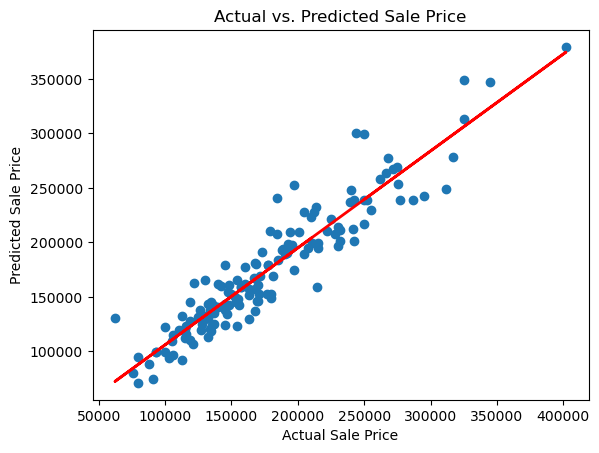

In [25]:
# Scatter plot for actual vs. predicted Sale Price
plt.scatter(y_test, y_test_pred.flatten())
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs. Predicted Sale Price")

# Add a line of best fit
fit = np.polyfit(y_test.flatten(), y_test_pred.flatten(), 1)
line = np.poly1d(fit)
plt.plot(y_test.flatten(), line(y_test.flatten()), color="red", linewidth=2)

plt.show()

In [26]:
# print the r_squared
print(f"R-squared: {r2_score(y_test, y_test_pred)}")

# and other metrics
print(f"Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred)}")
print(f"Mean Percentage Error: {np.mean((y_test - y_test_pred) / y_test) * 100}")

R-squared: 0.8800672697299794
Mean Squared Error: 439162197.73051107
Mean Absolute Error: 15165.742708333333
Mean Percentage Error: -10.556236674703808


In [27]:
# predict a baseline
# essentially, set every value to the mean and create a fake list of predictions
# compare to above model's predictions
baseline_prediction = y_train.mean()

# create array of baseline predictions with the length of y_test
baseline_predictions = [baseline_prediction] * len(y_test)

print(f"Baseline R-squared: {r2_score(y_test, baseline_predictions)}")
print(
    f"Baseline Mean Squared Error: {mean_squared_error(y_test, baseline_predictions)}"
)
print(
    f"Baseline Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}"
)
print(
    f"Mean Percentage Error: {np.mean((y_test - baseline_predictions) / y_test) * 100}"
)

Baseline R-squared: -9.767483872025196e-05
Baseline Mean Squared Error: 3662095341.601121
Baseline Mean Absolute Error: 48139.728422619046
Mean Percentage Error: -12.500385305330964


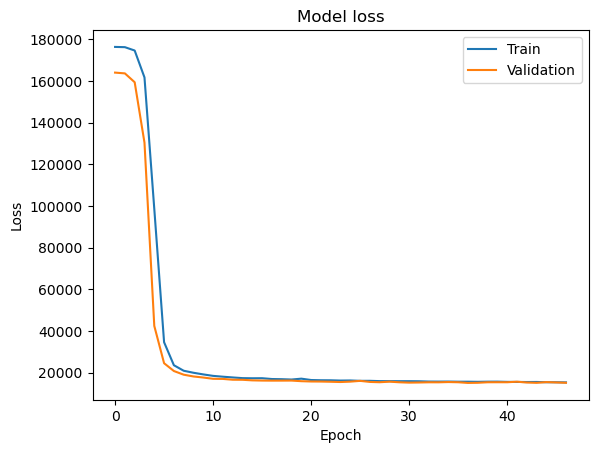

In [28]:
# plot training & validation loss values
# hopefully these both drop quickly and stabilize
# if not...
# validation loss up and training down? overfitting
# training and validation high? underfitting
plt.plot(fit_model.history["loss"])
plt.plot(fit_model.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")
plt.show()

5/5 [==============================] - 0s 1ms/step


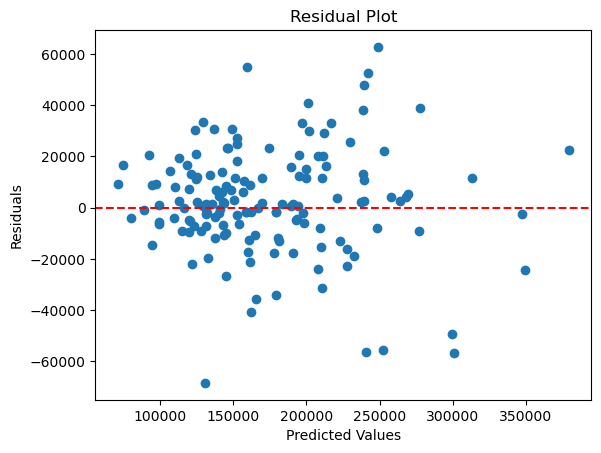

In [29]:
# residual plot
# difference between actual and predicted values
# you want there to be a rnadom distribution around the red line, zero
residuals = y_test - nn.predict(X_test).flatten()
plt.scatter(nn.predict(X_test).flatten(), residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

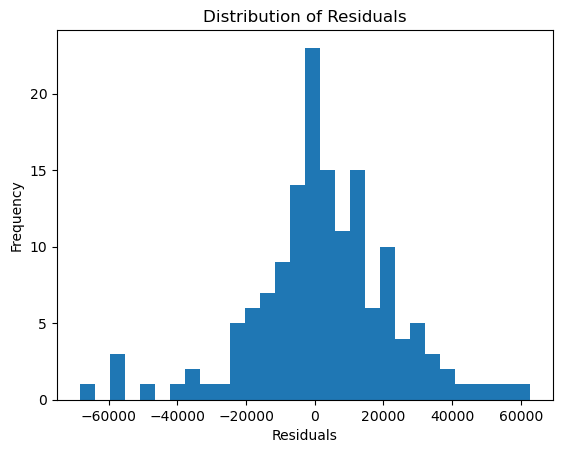

In [30]:
# distribution of residuals
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

In [31]:
# plot the learning curve?